In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rockpool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.0/593.0 kB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rockpool: filename=rockpool-2.9.2-py3-none-any.whl size=719722 sha256=cc610e281fe8888d8fbec2fe59ee52501b5be21764cd4ac903b2c46f738871d4
  Stored in directory: /root/.cache/pip/wheels/92/45/67/4c1edbaea8e283f7a87d99f9dac96406bc4a2501aef5f25575
Successfully built rockpool


In [ ]:
! pip install "rockpool[all]"

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.8/99.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# 加载数据
X = np.load('/content/drive/My Drive/X_all_new.npy')
y = np.load('/content/drive/My Drive/y_all_new.npy')

# 第一次分割：train (70%) 和 temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 第二次分割：val (15%) 和 test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 保存分割后的数据
np.save('/content/drive/My Drive/X_train_new.npy', X_train)
np.save('/content/drive/My Drive/y_train_new.npy', y_train)
np.save('/content/drive/My Drive/X_val_new.npy', X_val)
np.save('/content/drive/My Drive/y_val_new.npy', y_val)
np.save('/content/drive/My Drive/X_test_new.npy', X_test)
np.save('/content/drive/My Drive/y_test_new.npy', y_test)

print("分割完成：")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")



分割完成：
Train: (104991, 100, 16), Val: (22498, 100, 16), Test: (22499, 100, 16)


In [15]:
X_train,y_train = np.load('/content/drive/My Drive/SD-project/X_train.npy'), np.load('/content/drive/My Drive/SD-project/y_train.npy')

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def get_class_distribution(X, y, class_id):
    # Ensure input is a torch.Tensor
    X_tensor = torch.tensor(X) if isinstance(X, np.ndarray) else X
    y_tensor = torch.tensor(y) if isinstance(y, np.ndarray) else y

    # Extract all samples from the given class
    X_class = X_tensor[y_tensor == class_id]  # shape: (N, T, C)
    if X_class.shape[0] == 0:
        raise ValueError(f"No samples found for class {class_id}.")

    # Compute average spike distribution and normalize into a probability vector
    avg = X_class.float().mean(dim=0)  # shape: (T, C)
    p = avg.flatten()
    p = p / (p.sum() + 1e-8)  # Avoid division by zero
    return p.numpy()

def plot_class_spike_maps(X, y, num_classes=3):
    for class_id in range(num_classes):
        X_class = torch.tensor(X)[torch.tensor(y) == class_id]
        if len(X_class) == 0:
            continue
        avg = X_class.float().mean(dim=0)  # shape: (T, C)
        plt.imshow(avg.T, aspect='auto', cmap='hot')
        plt.title(f"Class {class_id} - Mean Spike Map")
        plt.xlabel("Time")
        plt.ylabel("Channel")
        plt.colorbar()
        plt.show()
    plt.savefig(f'/content/drive/My Drive/class_{class_id}_spike_map.png')

def summarize_spike_counts(X, y, num_classes=3):
    spike_count = torch.tensor(X).sum(dim=(1,2))  # shape: [N]
    for class_id in range(num_classes):
        count = spike_count[torch.tensor(y) == class_id]
        print(f"[Class {class_id}] Samples: {count.numel()}, Mean spikes: {count.float().mean():.2f}, Std: {count.float().std():.2f}")


def analyze_class_differences(X, y, num_classes=3):
    print("📊 [1] Total Spike Count Statistics by Class:")
    summarize_spike_counts(X, y, num_classes)

    print("\n🧠 [2] Average Spike Maps by Class:")
    plot_class_spike_maps(X, y, num_classes)

    print("\n📐 [3] Jensen-Shannon Distances Between Classes:")
    dists = {}
    for i in range(num_classes):
        for j in range(i+1, num_classes):
            p_i = get_class_distribution(X, y, i)
            p_j = get_class_distribution(X, y, j)
            js = jensenshannon(p_i, p_j)
            print(f"JS({i} || {j}) = {js:.4f}")
            dists[(i, j)] = js
    return dists


📊 [1] Total Spike Count Statistics by Class:
[Class 0] Samples: 35000, Mean spikes: 29.03, Std: 112.62
[Class 1] Samples: 35000, Mean spikes: 69.13, Std: 140.82
[Class 2] Samples: 35000, Mean spikes: 7.78, Std: 16.84

🧠 [2] Average Spike Maps by Class:


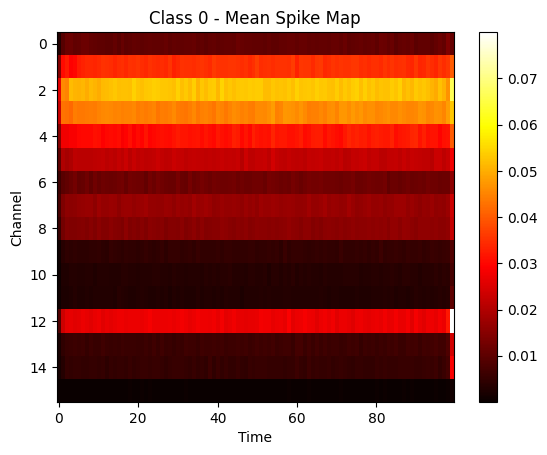

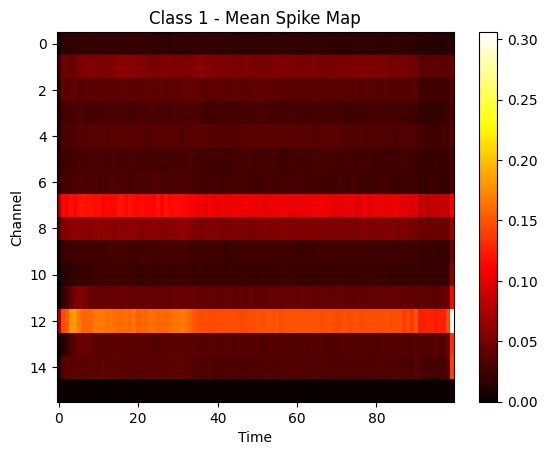

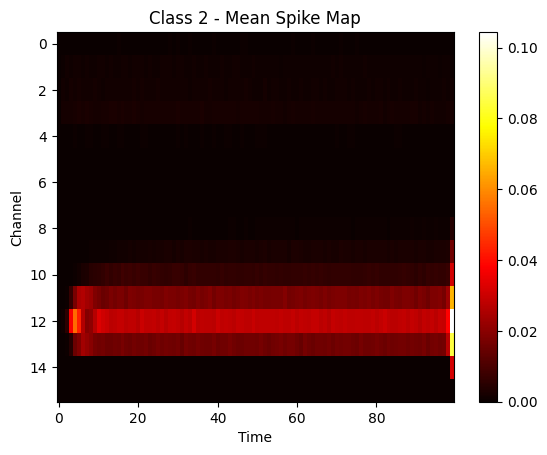


📐 [3] Jensen-Shannon Distances Between Classes:
JS(0 || 1) = 0.3089
JS(0 || 2) = 0.6001
JS(1 || 2) = 0.4566


{(0, 1): np.float32(0.30889738),
 (0, 2): np.float32(0.6001444),
 (1, 2): np.float32(0.45657787)}

<Figure size 640x480 with 0 Axes>

In [16]:
analyze_class_differences(X_train, y_train, num_classes=3)

In [13]:
import matplotlib.pyplot as plt

def plot_samples_per_class(X, y, num_classes=3, samples_per_class=1):
    plt.figure(figsize=(samples_per_class * 4, num_classes * 3))

    for class_id in range(num_classes):
        # 找出该类的索引
        idx = np.where(y == class_id)[0][:samples_per_class]

        for j, sample_idx in enumerate(idx):
            sample = X[sample_idx].T  # shape: (channels=16, time=100)

            ax = plt.subplot(num_classes, samples_per_class, class_id * samples_per_class + j + 1)
            ax.imshow(sample, aspect='auto', cmap='hot')
            ax.set_title(f"Class {class_id} | Index {sample_idx.item()}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Channel")

    plt.tight_layout()
    plt.show()


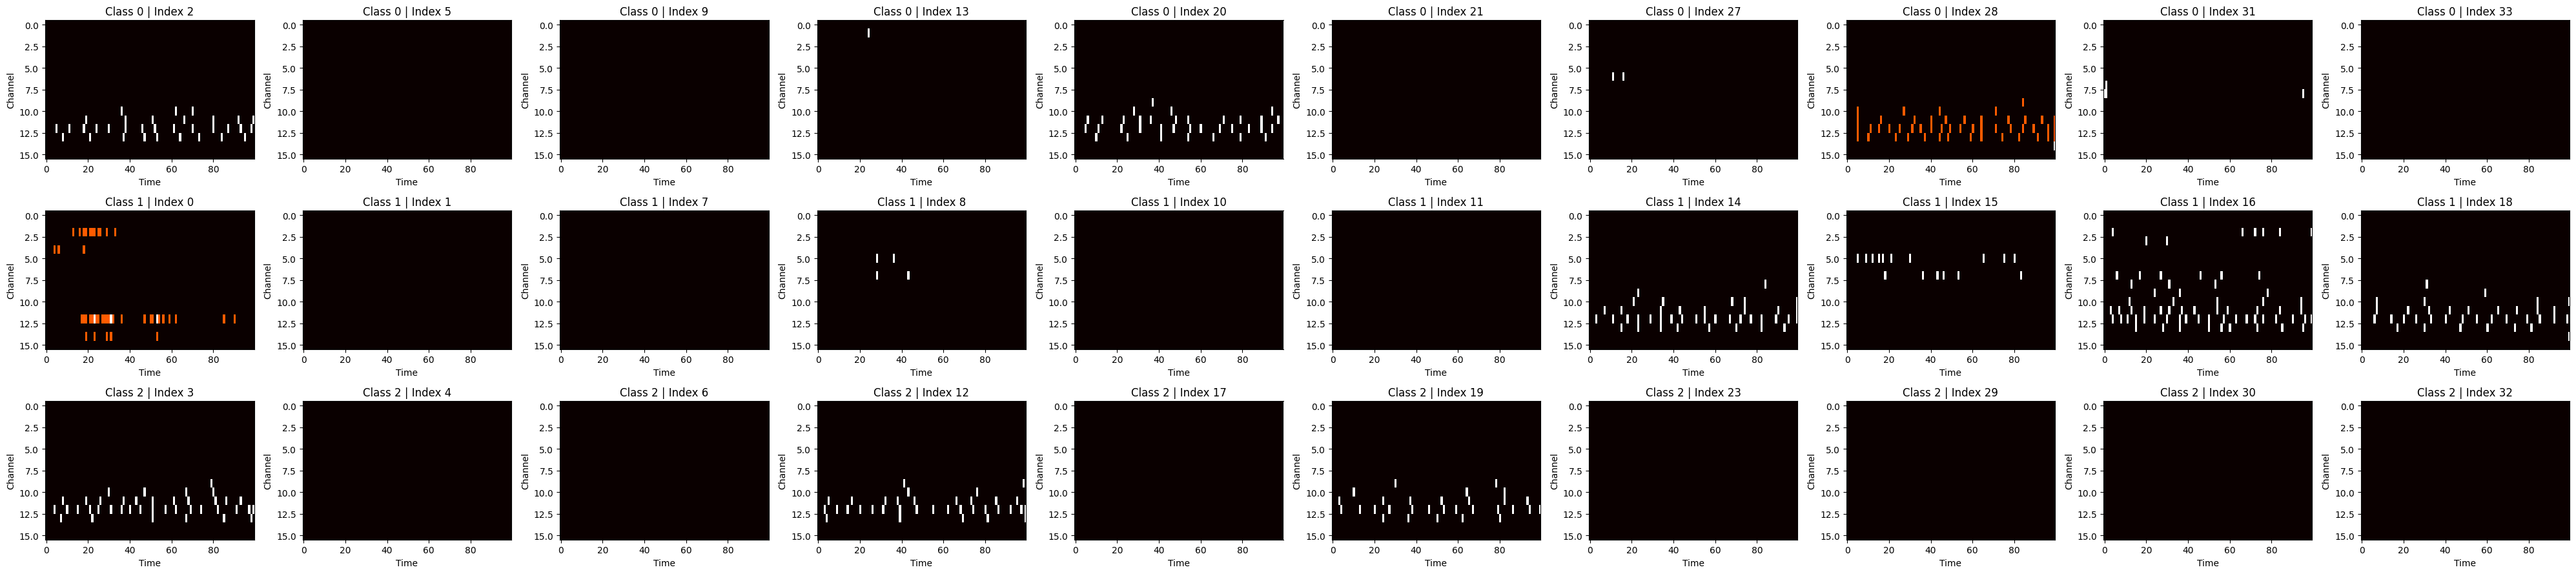

In [14]:
plot_samples_per_class(X_train, y_train, num_classes=3, samples_per_class=10)



In [ ]:
# ==== 3. 构建模型 ====
n_channels = 16
n_classes = 3

net = SynNet(
    output="vmem",
    p_dropout=0,
    n_channels=n_channels,
    n_classes=n_classes,
    size_hidden_layers=[64, 128, 128],
    time_constants_per_layer=[2, 4, 8],
).to(device)

optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# ==== 4. 定义损失函数 ====
def one_hot_mse_loss(outputs, labels, num_classes):
    target_onehot = F.one_hot(labels, num_classes=num_classes).float().to(outputs.device)
    return F.mse_loss(outputs, target_onehot)

# ==== 5. 开始训练 ====
n_epochs = 1000
best_val_acc = 0.0
best_state = None

for epoch in range(n_epochs):
    net.train()
    correct = 0
    total = 0
    total_loss = 0

    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        out, _, _ = net(xb)
        sum_out = torch.cumsum(out, dim=1)[:, -1, :]  # time axis = 1
        loss = one_hot_mse_loss(sum_out, yb, num_classes=n_classes)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        pred = torch.argmax(sum_out, dim=1)
        correct += (pred == yb.to(pred.device)).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / total
    acc = 100 * correct / total
    print(f"Epoch {epoch}: Train Loss={avg_loss:.4f}, Accuracy={acc:.2f}%")

    # ==== 验证 ====
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out, _, _ = net(xb)
            sum_out = torch.cumsum(out, dim=1)[:, -1, :]
            pred = torch.argmax(sum_out, dim=1)
            correct += (pred == yb.to(pred.device)).sum().sum().item()
            total += yb.size(0)

    val_acc = 100 * correct / total
    print(f"  [Val] Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = net.state_dict()
        torch.save(best_state, "/content/drive/My Drive/SD-project/best_snn_model.pth")
        print(f"  ✅ New best model saved at epoch {epoch} with val acc {val_acc:.2f}%")

print(f"\n🎯 Best Validation Accuracy: {best_val_acc:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(n_epochs))

# Accuracy Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()